In [4]:
import numpy as np
import lap
import time
import matplotlib.pyplot as plt

In [5]:
def super_algorithm(g_p, g_r, f, s, bids, h, trade_param, special=False):
    
    """Solve for a paper ordering for a reviewer using SUPER* procedure. 
    
    This procedure requires numpy and the lap package https://github.com/gatagat/lap 
    to solve the linear assignment problem. 
    
    :param g_p (function): Paper-side gain function mapping bid counts to a score. 
    The score function should be non-decreasing in the number of bids. 
    The function should handle the bid count input as an array containing 
    the number of bids for each paper ordered by the paper index or the 
    bid count input as a number for a fixed paper. 
    
    Ex/ g_p = lambda bids: np.sqrt(bids)
    
    :param g_r (function): Reviewer-side gain function mapping similarity score and paper position to a score.
    The score function should be non-decreasing in the similarity score and and non-increasing in the paper position.
    The function should handle the similarity score input and the paper position input as arrays containing the
    similarity scores and paper positions for each paper ordered by the paper index or the similarity score and 
    paper position for a fixed paper.
    
    Ex/ g_r = lambda s, pi: (2**s - 1)/np.log2(pi + 1)
    
    :param f (function): Bidding function mapping similarity score and paper position to a bid probability. 
    The function should be non-decreasing in the similarity score and non-increasing in the paper position. 
    The function should handle the similarity score imput and the paper position input as arrays containing 
    the similarity scores and paper positions for each paper ordered by the paper index or the similarity score 
    and paper position for a fixed paper.
    
    Ex/ f = lambda s, pi: s/np.log2(pi + 1)
    
    :param s (array): Similarity scores for each paper ordered by paper index.
    
    :param bids (array): Number of bids for each paper ordered by the paper index prior to the arrival of the reviewer.
    
    :param h (array): Heuristic values estimating the number of bids for each paper in the future ordered by the paper index. 
    
    :param trade_param (float): Parameter dictating the weight given to the reviewer-side gain function. 
    
    :param special (bool): indicator for the ability to use computationally effiicent solution. 
    If the reviewer-side gain function is multiplicatively separable into the form g_r(s, pi) = g_r_s(s)f_p(pi) 
    where g_r_s is a non-decreasing function of the similarity score and f_p is the non-increasing bidding function
    of the position a paper is shown and similarly the bidding function can be decomposed into the form 
    f(s, pi) = f_s(s)f_p(pi), then a simple sorting routine can be used instead of the linear program. To run the sorting
    procedure, the functions g_r and f should take in the paper ordering as an optional argument. 
    
    Ex/ If g_r(s, pi) = (2**s - 1)/np.log2(pi + 1) and f(s, pi) = s/np.log2(pi + 1), then special can be set and 
    define g_r(s, pi=None) = if pi is None: (2**s - 1) else: (2**s - 1)/np.log2(pi + 1) and similarly define
    f(s, pi=None) = if pi is None: s else: s/np.log2(pi + 1).
    
    return pi_t (array): Array containing the position each paper is to be presented ordered by paper index. For example, 
    pi_t = [2, 1] means paper 1 is presented in position 2, and paper 2 is presented in position 1. 
    """

    d = len(s)

    if not special:
        # Solve linear assignment problem to get ordering to present.
        w_p = lambda j,k: f(s[j], k)*(g_p(bids[j] + h[j] + 1) - g_p(bids[j]+h[j])) 
        w_r = lambda j,k: trade_param*g_r(s[j], k)
        w = np.array([w_p(j, np.arange(1, d+1)) + w_r(j, np.arange(1, d+1)) for j in range(d)])
        pi_t = lap.lapjv(-w)[1]
        pi_t += 1
    else:
        # Rank papers from maximum to minimum for alpha breaking ties by the similarity score.
        alpha = f(s)*(g_p(bids + h + 1) - g_p(bids + h)) + trade_param*g_r(s)
        alpha_pairs = np.array(zip(alpha, np.arange(1, d+1)), dtype=[('alpha', float), ('index', float)])        
        pi_t = np.argsort(np.lexsort((alpha_pairs['index'], -alpha_pairs['alpha'])))+1  

    return pi_t

## Example

In [6]:
# Configuration
num_papers = 100
g_p = lambda x: np.sqrt(x)

def g_r(s, pi=None): 
    if pi is None:
        return (2.**(s)-1)
    else:
        return (2.**(s)-1)/np.log2(pi + 1)
    
def f(s, pi=None): 
    if pi is None:
        return s
    else:
        return s/np.log2(pi + 1)

s = np.random.rand(num_papers)
bids = np.random.randint(0, 10, num_papers) 
h = np.random.rand(num_papers)
trade_param = 1

In [7]:
# Linear Program Method to Find Paper Ordering
pi_lp = super_algorithm(g_p, g_r, f, s, bids, h, trade_param, special=False)

In [8]:
# Sorting Method to Find Paper Ordering
pi_sort = super_algorithm(g_p, g_r, f, s, bids, h, trade_param, special=True)

In [9]:
# Equivalence
assert (pi_lp == pi_sort).all()

### Timing Comparison

In [12]:
lp_times = []
sort_times = []
num_paper_sweep = [100, 250, 500, 1000, 1500]

for num_papers in num_paper_sweep:
    
    s = np.random.rand(num_papers)
    bids = np.random.randint(0, 10, num_papers) 
    h = np.random.rand(num_papers)
    trade_param = 1

    start = time.time()
    # Linear Program Method to Find Paper Ordering
    pi_lp = super_algorithm(g_p, g_r, f, s, bids, h, trade_param, special=False)
    end = time.time()
    lp_times.append(end-start)
    
    start = time.time()
    # Sorting Method to Find Paper Ordering
    pi_sort = super_algorithm(g_p, g_r, f, s, bids, h, trade_param, special=True)
    end = time.time()
    sort_times.append(end-start)
    
    # Equivalence
    assert (pi_lp == pi_sort).all()

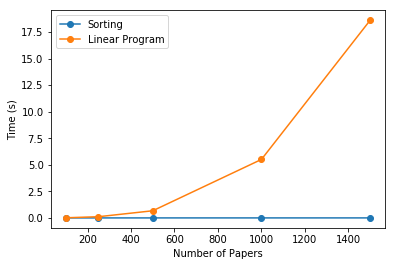

In [13]:
plt.plot(num_paper_sweep, sort_times, '-o', label='Sorting')
plt.plot(num_paper_sweep, lp_times, '-o', label='Linear Program')
plt.xlabel('Number of Papers')
plt.ylabel('Time (s)')
plt.legend()
plt.show()

In [14]:
lp_times = []
sort_times = []
num_paper_sweep = [100, 1000, 10000, 100000, 1000000]

for num_papers in num_paper_sweep:
    
    s = np.random.rand(num_papers)
    bids = np.random.randint(0, 10, num_papers) 
    h = np.random.rand(num_papers)
    trade_param = 1
    
    start = time.time()
    # Sorting Method to Find Paper Ordering
    pi_sort = super_algorithm(g_p, g_r, f, s, bids, h, trade_param, special=True)
    end = time.time()
    sort_times.append(end-start)

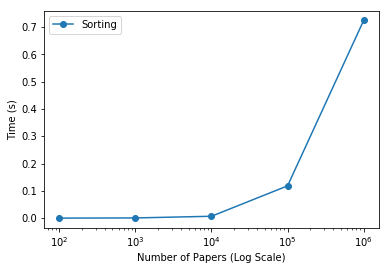

In [15]:
plt.plot(num_paper_sweep, sort_times, '-o', label='Sorting')
plt.xscale('log')
plt.xlabel('Number of Papers (Log Scale)')
plt.ylabel('Time (s)')
plt.legend()
plt.show()